## 1. Unzip Dataset

In [1]:
import zipfile
import os

zip_path = "TestDataSet.zip"
extract_to = "/home/arm9337"

# Ensure output directory exists
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzip complete. Contents:")
print(os.listdir(extract_to))

Unzip complete. Contents:
['Adversarial_Test_Set_3_PGD.pt', 'arm9337_HW3_Q3_32.ipynb', 'arm9337_HW2_Q4 (recieved2).ipynb', 'DL_P2_4a.ipynb', 'captions.txt', 'best_resnett10_model_a2.pth', '.triton', 'training_curves_a2.png', 'Untitled.ipynb', 'iter-PGD.png', 'arm9337_HW2_Q4.ipynb', 'DL_Project_2_final.ipynb', 'arm9337_HW3_Q3_64.ipynb', '.cache', 'Ori-FGSM.png', 'Project1_DL_a1.ipynb', 'Top-5.png', '__MACOSX', 'DL_Project3_Final.ipynb', 'arm9337_HW3_Q2.ipynb', 'test_unlabelled.pkl', 'DL_Project3.ipynb', 'submission_a2.csv', 'results', 'Project1_DL_a2.ipynb', 'training_curves1.png', 'DL_P2_8a.ipynb', 'submission_a3.csv', 'Top-1.png', '.nv', 'Adversarial_Test_Set_1.pt', '.jupyter', 'Project1_DL_a4.ipynb', 'DL_P2_5a.ipynb', '.local', 'flickr8k.zip', 'best_compresnett10_model_la.pth', 'Adversarial_Test_Set_3_Optimal.pt', 'Ori-PatchPGD.png', 'Project1_DL_a5.ipynb', 'DL_P2_9a.ipynb', 'demo13-clip.ipynb', 'DL_P2_2.ipynb', '.ipython', 'arm9337_HW2_Q4 (1).ipynb', '.ipynb_checkpoints', '.data', '

## 2. Imports and Setup

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34, densenet121
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import json
import os
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt

## 3. Define Preprocessing and Load Dataset

In [3]:
import os

# Point this at wherever you unzipped TestDataSet.zip
base_dir = "/home/arm9337/TestDataSet"

print("Top‐level contents of", base_dir)
for name in os.listdir(base_dir):
    print(" ", name)

Top‐level contents of /home/arm9337/TestDataSet
  n02769748
  n02966687
  n02730930
  n02965783
  n02980441
  n02727426
  n02950826
  n02797295
  n02910353
  n02793495
  n02999410
  n02676566
  n03017168
  n02802426
  n02865351
  n02917067
  n02966193
  n02892767
  n02708093
  n02859443
  n02701002
  n02699494
  n02981792
  n02963159
  n02749479
  n02877765
  n03026506
  n02992211
  n02988304
  labels_list.json
  n02692877
  n02790996
  n03032252
  n02795169
  n02823428
  n02841315
  n02777292
  n03028079
  n02835271
  n02840245
  n02974003
  n02948072
  n03000684
  n02814533
  n02939185
  n02808304
  n02843684
  n02894605
  n02786058
  n02804414
  n02930766
  n02787622
  n02823750
  n02909870
  n02879718
  n03042490
  n03000247
  n02895154
  n02892201
  n02794156
  n02704792
  n02860847
  n02979186
  n02951358
  n02883205
  n03014705
  n02869837
  n02992529
  n02951585
  n02791124
  n02687172
  n02916936
  n02791270
  n02971356
  n02788148
  n02782093
  .DS_Store
  n02834397
  n030416

In [4]:
import os
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# 1. Preprocessing
mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# 2. Point to the folder that directly holds your class‐named subdirectories
dataset_path = "/home/arm9337/TestDataSet"
print("Loading images from:", dataset_path)

# 3. Load with ImageFolder
dataset    = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Quick sanity check
print(f"Found {len(dataset.classes)} classes and {len(dataset)} images.")


Loading images from: /home/arm9337/TestDataSet
Found 100 classes and 500 images.


## 4. Load ResNet-34 Pretrained Model

In [5]:
model = resnet34(weights='IMAGENET1K_V1')
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Load Label Mapping

In [6]:
import json, os

json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, "r") as f:
    labels_list = json.load(f)   # a Python list of length 100



In [7]:
print(type(labels_list), len(labels_list))
print("First 5 entries:", labels_list[:5])
print("Types:", [type(x) for x in labels_list[:5]])


<class 'list'> 100
First 5 entries: ['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']
Types: [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [8]:
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    raw_list = json.load(f)

# Extract the numeric part before the colon and convert to int
labels_list = [int(entry.split(":")[0]) for entry in raw_list]

print("First 5 cleaned ImageNet indices:", labels_list[:5])


First 5 cleaned ImageNet indices: [401, 402, 403, 404, 405]


## 6. Evaluate Model on Dataset

In [9]:
total, top1, top5 = 0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.cuda()
        outputs = model(images)

        preds1 = outputs.topk(1, dim=1).indices.view(-1)    # shape [B]
        preds5 = outputs.topk(5, dim=1).indices              # shape [B, 5]

        # Convert local label indices (0–99) to ImageNet indices (0–999)
        true_global = torch.tensor(
            [labels_list[l] for l in labels.cpu().numpy()],
            device=preds1.device
        )

        # Top-1 Accuracy
        top1 += (preds1 == true_global).sum().item()

        # Top-5 Accuracy
        for i in range(labels.size(0)):
            if true_global[i].item() in preds5[i].tolist():
                top5 += 1

        total += labels.size(0)

print(f"Top-1 Accuracy: {top1 / total:.4f}")
print(f"Top-5 Accuracy: {top5 / total:.4f}")


100%|██████████| 16/16 [00:05<00:00,  2.80it/s]

Top-1 Accuracy: 0.7620
Top-5 Accuracy: 0.9420


In [10]:
def fgsm_attack(input_img, data_grad, epsilon_norm, min_norm, max_norm):
    """
    Perform FGSM attack on a batch of images in normalized space.
    input_img: normalized images tensor
    data_grad: gradient w.r.t. input_img
    epsilon_norm: channel-wise epsilon normalized
    """
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed = input_img + epsilon_norm * sign_data_grad
    # Clamp to valid range
    perturbed = torch.max(torch.min(perturbed, max_norm), min_norm)
    return perturbed

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_norm_bounds(epsilon):
    eps_norm = torch.tensor([epsilon/s for s in std_norms], device=device).view(3,1,1)
    min_norm = torch.tensor([(0-m)/s for m,s in zip(mean_norms,std_norms)], device=device).view(3,1,1)
    max_norm = torch.tensor([(1-m)/s for m,s in zip(mean_norms,std_norms)], device=device).view(3,1,1)
    return eps_norm, min_norm, max_norm

def evaluate_fgsm(epsilon):
    eps_norm, min_norm, max_norm = compute_norm_bounds(epsilon)
    correct1, correct5, total = 0, 0, 0
    model.eval()
    for imgs, labels in tqdm(dataloader, desc=f'FGSM ε={epsilon:.3f}'):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs.requires_grad = True

        outputs = model(imgs)
        true_global = torch.tensor([labels_list[l] for l in labels.cpu().numpy()], device=device)
        loss = torch.nn.functional.cross_entropy(outputs, true_global)
        model.zero_grad(); loss.backward()
        data_grad = imgs.grad.data

        perturbed = fgsm_attack(imgs, data_grad, eps_norm, min_norm, max_norm)
        out_adv = model(perturbed)

        p1 = out_adv.topk(1, dim=1).indices.view(-1)
        p5 = out_adv.topk(5, dim=1).indices

        correct1 += (p1 == true_global).sum().item()
        for i in range(labels.size(0)):
            if true_global[i].item() in p5[i].tolist():
                correct5 += 1
        total += labels.size(0)

    return correct1/total, correct5/total

In [12]:
# Attack budget
epsilon = 0.02  # raw pixel budget

# Normalization parameters (from Task 1)
mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute normalized epsilon per channel
import torch
epsilon_norm = torch.tensor([epsilon / s for s in std_norms], device=device).view(3,1,1)

# Compute valid pixel bounds in normalized space
min_norm = torch.tensor([(0 - m) / s for m,s in zip(mean_norms,std_norms)], device=device).view(3,1,1)
max_norm = torch.tensor([(1 - m) / s for m,s in zip(mean_norms,std_norms)], device=device).view(3,1,1)

print('Epsilon norm:', epsilon_norm)

Epsilon norm: tensor([[[0.0873]],

        [[0.0893]],

        [[0.0889]]], device='cuda:0')


In [13]:
# Set model to eval mode (no dropout, etc.)
model.eval()

# for visualization
adv_examples = []

# for saving the full set
adv_images_all = []
adv_labels_all = []

# accuracy counters
correct1, correct5, total = 0, 0, 0

for imgs, labels in tqdm(dataloader, desc='FGSM Attack'):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs.requires_grad = True

    # Forward pass + loss
    outputs = model(imgs)
    true_global = torch.tensor(
        [labels_list[l] for l in labels.cpu().numpy()],
        device=device
    )
    loss = torch.nn.functional.cross_entropy(outputs, true_global)

    # Backward pass
    model.zero_grad()
    loss.backward()
    data_grad = imgs.grad.data

    # FGSM attack
    perturbed_data = fgsm_attack(imgs, data_grad, epsilon_norm, min_norm, max_norm)
    # Check L∞ constraint for FGSM
    delta = (perturbed_data - imgs).detach()
    # Convert the per‐channel epsilon_norm tensor to a single float bound
    eps_val = epsilon_norm.max().item()
    # Now assert correctly
    assert delta.abs().max().item() <= eps_val + 1e-5, f"FGSM ε-constraint violated: max perturbation {delta.abs().max().item():.6f} > {eps_val:.6f}"

    # ---- accumulate full adversarial set ----
    adv_images_all.append(perturbed_data.detach().cpu())
    adv_labels_all.append(true_global.detach().cpu())

    # Re-classify perturbed images
    output_adv = model(perturbed_data)

    # Compute top-1 and top-5
    preds1 = output_adv.topk(1, dim=1).indices.view(-1)
    preds5 = output_adv.topk(5, dim=1).indices

    # Count correct
    correct1 += (preds1 == true_global).sum().item()
    for i in range(labels.size(0)):
        if true_global[i].item() in preds5[i]:
            correct5 += 1
    total += labels.size(0)

    # Save a few examples for visualization
    if len(adv_examples) < 5:
        for i in range(min(5 - len(adv_examples), imgs.size(0))):
            adv_examples.append((
                imgs[i].detach().cpu(),
                perturbed_data[i].detach().cpu(),
                true_global[i].item(),
                preds1[i].item()
            ))

# Concatenate and save the full adversarial set
adv_images_all = torch.cat(adv_images_all, dim=0)
adv_labels_all = torch.cat(adv_labels_all, dim=0)
torch.save((adv_images_all, adv_labels_all), "Adversarial_Test_Set_1.pt")
print("Saved FGSM set:", adv_images_all.shape)

# Finally, print the accuracy metrics
print(f"FGSM Top-1 Accuracy: {correct1/total:.4f}")
print(f"FGSM Top-5 Accuracy: {correct5/total:.4f}")

FGSM Attack: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]


Saved FGSM set: torch.Size([500, 3, 224, 224])
FGSM Top-1 Accuracy: 0.0340
FGSM Top-5 Accuracy: 0.2120


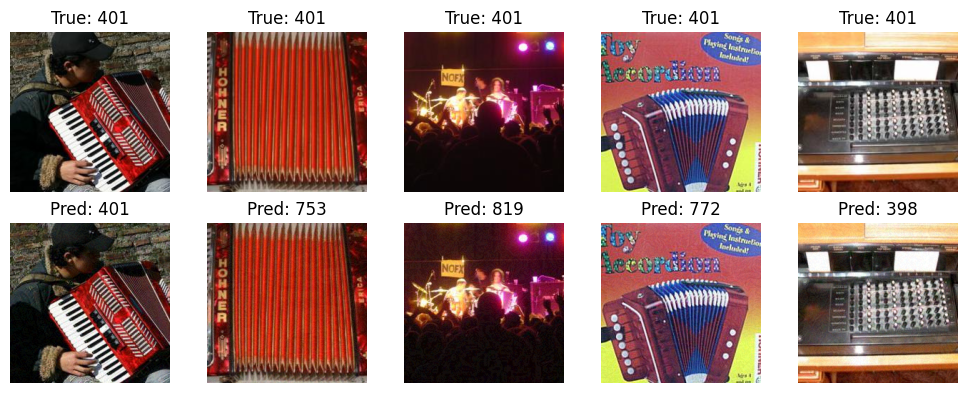

In [14]:
def denormalize(img_tensor):
    """Convert a normalized tensor to [0,1] range"""
    img = img_tensor.clone()
    for c, (m, s) in enumerate(zip(mean_norms, std_norms)):
        img[c] = img[c] * s + m
    return img

# Visualize up to 5 examples: original vs adversarial
plt.figure(figsize=(10, 4))
for idx, (orig, adv, true_lbl, adv_pred) in enumerate(adv_examples):
    # Original
    plt.subplot(2, len(adv_examples), idx+1)
    plt.imshow(denormalize(orig).permute(1,2,0).clamp(0,1))
    plt.title(f"True: {true_lbl}")
    plt.axis('off')
    # Adversarial
    plt.subplot(2, len(adv_examples), len(adv_examples)+idx+1)
    plt.imshow(denormalize(adv).permute(1,2,0).clamp(0,1))
    plt.title(f"Pred: {adv_pred}")
    plt.axis('off')
plt.tight_layout()
plt.savefig("Ori-FGSM.png")
plt.show()

In [15]:
save_dir = "/home/arm9337/Adversarial_Test_Set_1"
os.makedirs(save_dir, exist_ok=True)

for i, (_, adv, _, _) in enumerate(adv_examples):
    # Denormalize and save each example image
    img = denormalize(adv)
    vutils.save_image(img, os.path.join(save_dir, f"adv_{i}.png"))

print(f"Saved sample adversarial images to {save_dir}")

Saved sample adversarial images to /home/arm9337/Adversarial_Test_Set_1


In [16]:
def evaluate_pgd(model, dataloader, epsilon, alpha, iters, device, labels_list):
    model.eval()
    correct1 = correct5 = total = 0

    for imgs, local_labels in dataloader:
        imgs = imgs.to(device)
        # map to global ImageNet labels
        global_labels = torch.tensor(
            [labels_list[int(l)] for l in local_labels.cpu().numpy()],
            device=device
        )

        adv = imgs.detach().clone().requires_grad_(True)
        for _ in range(iters):
            out = model(adv)
            loss = F.cross_entropy(out, global_labels)
            model.zero_grad()
            loss.backward()
            adv = adv + alpha * adv.grad.sign()
            delta = torch.clamp(adv - imgs, -epsilon, epsilon)
            adv = torch.clamp(imgs + delta, 0, 1).detach().requires_grad_(True)

        with torch.no_grad():
            out_adv = model(adv)
            # Top-1
            preds1 = out_adv.argmax(dim=1)
            correct1 += (preds1 == global_labels).sum().item()
            # Top-5
            top5 = out_adv.topk(5, dim=1)[1]
            for i in range(global_labels.size(0)):
                if global_labels[i].item() in top5[i]:
                    correct5 += 1
            total += global_labels.size(0)

    return correct1/total, correct5/total

PGD iters= 1 → Top-1 = 34.60%
PGD iters= 5 → Top-1 = 1.00%
PGD iters=10 → Top-1 = 0.40%
PGD iters=20 → Top-1 = 0.40%
PGD iters=50 → Top-1 = 0.40%


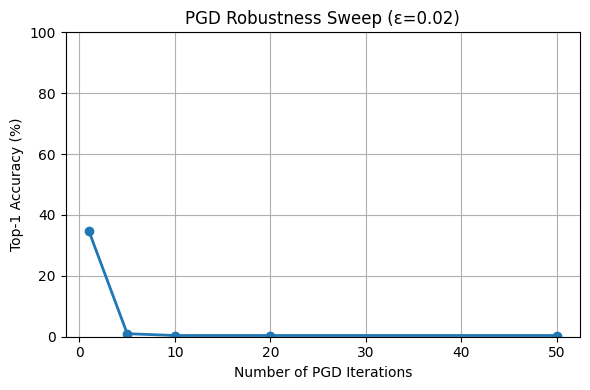

In [17]:
import matplotlib.pyplot as plt

# --- Parameters ---
eps = 0.02
alpha = eps / 4
iteration_list = [1, 5, 10, 20, 50]

top1_accs = []
for n in iteration_list:
    t1, _ = evaluate_pgd(model, dataloader, eps, alpha, n, device, labels_list)
    pct = t1 * 100
    print(f"PGD iters={n:2d} → Top-1 = {pct:.2f}%")
    top1_accs.append(pct)

plt.figure(figsize=(6,4))
plt.plot(iteration_list, top1_accs, marker='o', linewidth=2)
plt.xlabel('Number of PGD Iterations')
plt.ylabel('Top-1 Accuracy (%)')
plt.title(f'PGD Robustness Sweep (ε={eps})')
plt.ylim(0,100)
plt.grid(True)
plt.tight_layout()
plt.savefig("iter-PGD.png")
plt.show()

In [18]:
# ───── Phase 3.1: PGD Attack ─────

# 1) Attack hyper-parameters
eps   = 0.02           # total L∞ budget
alpha = eps / 4        # step size
iters = 10             # number of steps

# 2) PGD function (reuse or redefine here)


# Compute the epsilon in normalized space
eps_normalized = torch.tensor([eps/s for s in std_norms], device=device).view(3, 1, 1)

# Compute valid pixel bounds in normalized space
min_norm = torch.tensor([(0-m)/s for m,s in zip(mean_norms, std_norms)], device=device).view(3, 1, 1)
max_norm = torch.tensor([(1-m)/s for m,s in zip(mean_norms, std_norms)], device=device).view(3, 1, 1)

# Modified PGD attack function with normalized epsilon
def pgd_attack_normalized(model, images, labels, eps_norm, min_norm, max_norm, alpha_factor=0.25, iters=10):
    """
    PGD attack with normalized epsilon values - fixed for broadcasting
    """
    # Ensure all tensors are float32
    images = images.clone().detach().float()
    labels = labels.clone().detach()
    orig_images = images.clone().detach()
    
    # Ensure correct dtype and shape for parameter tensors
    eps_norm = eps_norm.float()
    min_norm = min_norm.float()
    max_norm = max_norm.float()
    
    # Debug shapes
    print(f"Inside attack - Images shape: {images.shape}, eps_norm shape: {eps_norm.shape}")
    
    # Use alpha as fraction of epsilon for each channel
    alpha_norm = eps_norm * alpha_factor
    
    # Random start - Careful with broadcasting
    # Generate random noise between -1 and 1 for batch
    noise = torch.zeros_like(images).uniform_(-1, 1)
    # Apply epsilon per channel (should broadcast correctly)
    delta = noise * eps_norm
    images = torch.clamp(images + delta, min_norm, max_norm).detach()
    
    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        
        # FGSM step
        # Get sign of gradient and apply channel-wise alpha
        grad_sign = data_grad.sign()
        perturb = alpha_norm * grad_sign  # Should broadcast correctly
        adv_images = images.detach() + perturb
        
        # Project back to epsilon ball around original image
        # Calculate the perturbation from original
        delta = adv_images - orig_images
        
        # Clamp perturbation to epsilon ball - should broadcast properly
        # For each channel c: -eps[c] <= delta[c] <= eps[c]
        clamped_delta = torch.zeros_like(delta)
        for c in range(3):  # For each channel
            channel_eps = eps_norm[c, 0, 0]  # Get scalar epsilon for this channel
            clamped_delta[:, c] = torch.clamp(delta[:, c], -channel_eps, channel_eps)
        
        # Apply clamped perturbation to original images
        images = torch.clamp(orig_images + clamped_delta, min_norm, max_norm).detach()
    
    return images
# 3) Run PGD over the dataset with normalized epsilon# 
model.eval()
adv_images_all, adv_labels_all = [], []

# Define your normalization values
mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Calculate normalized epsilon values
eps_normalized = torch.tensor([eps/s for s in std_norms], 
                              device=device, dtype=torch.float32).view(3, 1, 1)
min_norm = torch.tensor([(0-m)/s for m,s in zip(mean_norms, std_norms)], 
                         device=device, dtype=torch.float32).view(3, 1, 1)
max_norm = torch.tensor([(1-m)/s for m,s in zip(mean_norms, std_norms)], 
                         device=device, dtype=torch.float32).view(3, 1, 1)

print(f"Epsilon normalized shape: {eps_normalized.shape}, dtype: {eps_normalized.dtype}")
print(f"Min norm shape: {min_norm.shape}, dtype: {min_norm.dtype}")
print(f"Max norm shape: {max_norm.shape}, dtype: {max_norm.dtype}")

# Clear CUDA cache
torch.cuda.empty_cache()

for imgs, labs in tqdm(dataloader, desc="PGD Attack (Normalized)"):
    imgs = imgs.to(device, dtype=torch.float32)
    global_labs = torch.tensor([labels_list[l] for l in labs.numpy()], 
                                device=device)
    
    # Print shapes for debugging
    if len(adv_images_all) == 0:
        print(f"Image batch shape: {imgs.shape}, dtype: {imgs.dtype}")
        print(f"Labels shape: {global_labs.shape}")
    
    try:
        # Run the attack with normalized epsilon
        adv = pgd_attack_normalized(model, imgs, global_labs, eps_normalized, min_norm, max_norm)
        
        # Verify constraint in normalized space
        # Check channel-wise constraints
        delta = (adv - imgs).abs()
        
        # Check per channel
        constraint_violated = False
        for c in range(3):
            max_pert_c = delta[:, c].max().item()
            eps_c = eps_normalized[c, 0, 0].item()
            if max_pert_c > eps_c + 1e-5:
                print(f"Channel {c} violated: {max_pert_c} > {eps_c}")
                constraint_violated = True
        
        if not constraint_violated:
            print("L∞ constraints satisfied for all channels!")
        
        adv_images_all.append(adv.cpu())
        adv_labels_all.append(global_labs.cpu())
        
    except Exception as e:
        print(f"Error during attack: {e}")
        import traceback
        traceback.print_exc()  # Print full stack trace
        continue

# Only process completed batches
if adv_images_all:
    adv_images_all = torch.cat(adv_images_all)
    adv_labels_all = torch.cat(adv_labels_all)
    torch.save((adv_images_all, adv_labels_all), "Adversarial_Test_Set_2.pt")
    print("Done PGD, saved shape:", adv_images_all.shape)
else:
    print("No successful attacks completed.")

Epsilon normalized shape: torch.Size([3, 1, 1]), dtype: torch.float32
Min norm shape: torch.Size([3, 1, 1]), dtype: torch.float32
Max norm shape: torch.Size([3, 1, 1]), dtype: torch.float32


PGD Attack (Normalized):   0%|          | 0/16 [00:00<?, ?it/s]

Image batch shape: torch.Size([32, 3, 224, 224]), dtype: torch.float32
Labels shape: torch.Size([32])
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):   6%|▋         | 1/16 [00:00<00:04,  3.16it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  12%|█▎        | 2/16 [00:00<00:04,  3.39it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  19%|█▉        | 3/16 [00:00<00:03,  3.49it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  25%|██▌       | 4/16 [00:01<00:03,  3.50it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  31%|███▏      | 5/16 [00:01<00:03,  3.54it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  38%|███▊      | 6/16 [00:01<00:02,  3.56it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  44%|████▍     | 7/16 [00:01<00:02,  3.58it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  50%|█████     | 8/16 [00:02<00:02,  3.59it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  56%|█████▋    | 9/16 [00:02<00:01,  3.60it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  62%|██████▎   | 10/16 [00:02<00:01,  3.59it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  69%|██████▉   | 11/16 [00:03<00:01,  3.59it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  75%|███████▌  | 12/16 [00:03<00:01,  3.57it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  81%|████████▏ | 13/16 [00:03<00:00,  3.56it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  88%|████████▊ | 14/16 [00:03<00:00,  3.55it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([32, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized):  94%|█████████▍| 15/16 [00:04<00:00,  3.56it/s]

L∞ constraints satisfied for all channels!
Inside attack - Images shape: torch.Size([20, 3, 224, 224]), eps_norm shape: torch.Size([3, 1, 1])


PGD Attack (Normalized): 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]

L∞ constraints satisfied for all channels!


Done PGD, saved shape: torch.Size([500, 3, 224, 224])


In [19]:
# ─── Phase 3.2: Evaluate PGD Adversarial Set ───
batch_size = 32
total, top1, top5 = 0, 0, 0

model.eval()
with torch.no_grad():
    for i in range(0, len(adv_images_all), batch_size):
        batch_imgs = adv_images_all[i : i+batch_size].to(device)
        batch_labs = adv_labels_all[i : i+batch_size].to(device)

        outputs = model(batch_imgs)
        preds1  = outputs.topk(1, dim=1).indices.view(-1)
        preds5  = outputs.topk(5, dim=1).indices

        top1 += (preds1 == batch_labs).sum().item()
        for j in range(batch_labs.size(0)):
            if batch_labs[j].item() in preds5[j].tolist():
                top5 += 1
        total += batch_labs.size(0)

print(f"PGD Top-1 Accuracy: {top1/total:.4f}")
print(f"PGD Top-5 Accuracy: {top5/total:.4f}")

PGD Top-1 Accuracy: 0.0000
PGD Top-5 Accuracy: 0.0100


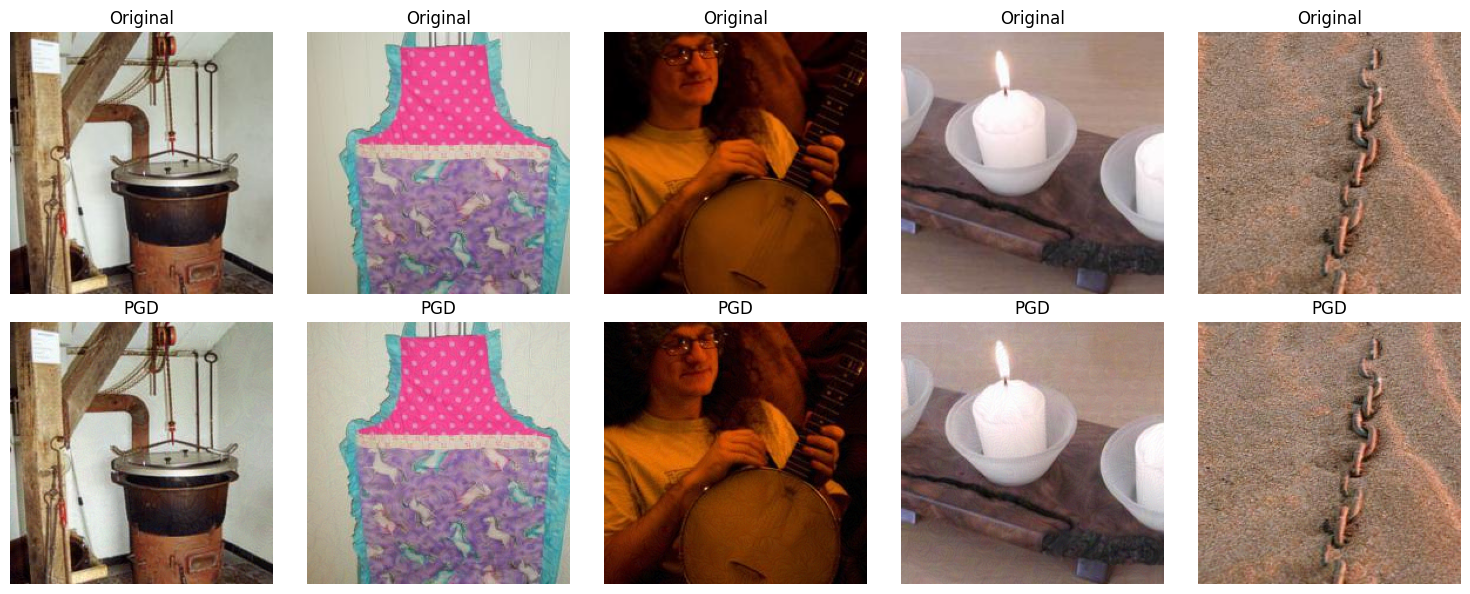

In [20]:
# De-normalization constants
mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]

# 1) Pick 5 random indices
idxs = np.random.choice(len(adv_images_all), size=5, replace=False)

# 2) Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(idxs):
    # Original
    orig = (dataloader.dataset[idx][0] * torch.tensor(std_norms)[:,None,None] +
            torch.tensor(mean_norms)[:,None,None]).permute(1,2,0).numpy()
    # PGD adv
    adv  = (adv_images_all[idx] * torch.tensor(std_norms)[:,None,None] +
            torch.tensor(mean_norms)[:,None,None]).permute(1,2,0).numpy()

    axes[0, i].imshow(np.clip(orig, 0, 1))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(np.clip(adv, 0, 1))
    axes[1, i].axis('off')
    axes[1, i].set_title("PGD")

plt.tight_layout()
plt.savefig("Ori-PGD.png")
plt.show()

In [21]:
# ───── Phase 4: Hyperparameter Sweep for Optimal Patch Attack ─────
import math
import torch.nn.functional as F
import itertools
from datetime import datetime

# Hyperparameter range to sweep
eps_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_divisors = [4, 8, 16, 20, 25]
iter_values = [40, 50, 80, 100, 120, 150, 170, 200]

# Function to create adversarial pattern (same as before)
def create_adversarial_pattern(patch_size, device):
    """Create a high-contrast adversarial pattern for initialization"""
    # Checkerboard pattern
    checker = torch.ones(patch_size, patch_size)
    for i in range(patch_size):
        for j in range(patch_size):
            if (i + j) % 2 == 0:
                checker[i, j] = -1
                
    # Create different patterns for each channel for more diversity
    pattern = torch.zeros(3, patch_size, patch_size)
    pattern[0] = checker
    pattern[1] = -checker  # Inverted for second channel
    # Sine wave pattern for third channel
    x = torch.linspace(0, 2*math.pi, patch_size)
    y = torch.linspace(0, 2*math.pi, patch_size)
    xx, yy = torch.meshgrid(x, y)
    pattern[2] = torch.sin(xx) * torch.cos(yy)
    
    return pattern.to(device)

# Improved patch PGD attack (same core algorithm but with variable hyperparameters)
def improved_patch_pgd_attack(model, images, labels, eps, alpha, iters, patch_size):
    """Enhanced PGD attack on a random patch with variable hyperparameters"""
    batch_size = images.shape[0]
    device = images.device
    _, _, H, W = images.shape
    
    # Original images for reference
    orig_images = images.clone().detach()
    perturbed_images = images.clone().detach()
    
    # Create patch masks - one per image in batch
    masks = torch.zeros_like(perturbed_images)
    
    # For each image, create random patch location
    for i in range(batch_size):
        # Random position (ensuring patch fits within image)
        y_pos = torch.randint(0, H - patch_size + 1, (1,)).item()
        x_pos = torch.randint(0, W - patch_size + 1, (1,)).item()
        
        # Create mask for this image
        masks[i, :, y_pos:y_pos+patch_size, x_pos:x_pos+patch_size] = 1.0
        
        # Initialize with adversarial pattern
        pattern = create_adversarial_pattern(patch_size, device)
        pattern = pattern * eps * 0.5  # Scale pattern to be within epsilon
        perturbed_images[i, :, y_pos:y_pos+patch_size, x_pos:x_pos+patch_size] += pattern
    
    # Ensure initial perturbation is within bounds
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
    # PGD attack loop
    for step in range(iters):
        perturbed_images.requires_grad = True
        
        # Forward pass
        outputs = model(perturbed_images)
        
        # For targeted attack: target the second most confident class
        _, sorted_indices = outputs.sort(dim=1, descending=True)
        target_classes = torch.zeros_like(labels)
        
        for i in range(batch_size):
            # Get the most likely class that's not the true class
            for idx in range(outputs.size(1)):  # Loop through all classes
                if sorted_indices[i, idx].item() != labels[i].item():
                    target_classes[i] = sorted_indices[i, idx]
                    break
        
        # Enhanced loss: combination of reducing true class probability and increasing target class
        # Use log probabilities for better gradients
        log_probs = F.log_softmax(outputs, dim=1)
        true_class_log_prob = log_probs.gather(1, labels.unsqueeze(1)).squeeze()
        target_class_log_prob = log_probs.gather(1, target_classes.unsqueeze(1)).squeeze()
        
        # Maximize target class probability while minimizing true class probability
        loss = true_class_log_prob - target_class_log_prob
        loss = loss.mean()
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Extract and apply gradients within patch only
        grad = perturbed_images.grad.data
        scaled_grad = alpha * grad.sign()
        
        # Apply gradient only within patch (using mask)
        adv_images = perturbed_images.detach() - scaled_grad * masks
        
        # Project perturbation back to epsilon-ball and valid pixel range
        delta = adv_images - orig_images
        delta = delta * masks  # Keep perturbation only in patch area
        delta = torch.clamp(delta, -eps, eps)  # Project to epsilon ball
        
        perturbed_images = torch.clamp(orig_images + delta, 0, 1).detach()
        
        # Print progress occasionally (only for verbose runs)
        if False and (step % 20 == 0 or step == iters - 1):
            with torch.no_grad():
                curr_outputs = model(perturbed_images)
                curr_preds = curr_outputs.argmax(dim=1)
                accuracy = (curr_preds == labels).float().mean().item()
                print(f"Step {step}/{iters}, Current accuracy: {accuracy:.4f}")
    
    return perturbed_images

# Function to evaluate attack performance
def evaluate_attack(model, images, labels, batch_size=32):
    """Evaluate attack performance"""
    device = next(model.parameters()).device
    total, top1, top5 = 0, 0, 0
    
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch_imgs = images[i : i+batch_size].to(device)
            batch_labs = labels[i : i+batch_size].to(device)
            outputs = model(batch_imgs)
            preds1 = outputs.topk(1, dim=1).indices.view(-1)
            preds5 = outputs.topk(5, dim=1).indices
            top1 += (preds1 == batch_labs).sum().item()
            for j in range(batch_labs.size(0)):
                if batch_labs[j].item() in preds5[j].tolist():
                    top5 += 1
            total += batch_labs.size(0)
    
    return top1/total, top5/total

# Create a sample dataset for quick hyperparameter sweep
def create_sample_dataset(dataloader, num_samples=50):
    """Create a smaller dataset for hyperparameter tuning"""
    sample_images, sample_labels = [], []
    count = 0
    
    for imgs, labs in dataloader:
        # Map local labels to ImageNet indices
        global_labs = torch.tensor([labels_list[l] for l in labs.numpy()])
        
        # Add to sample dataset
        sample_images.append(imgs)
        sample_labels.append(global_labs)
        
        count += imgs.size(0)
        if count >= num_samples:
            break
    
    return torch.cat(sample_images[:num_samples]), torch.cat(sample_labels[:num_samples])

# Create sample dataset for hyperparameter sweep
print("Creating sample dataset for hyperparameter tuning...")
sample_images, sample_labels = create_sample_dataset(dataloader)
print(f"Sample dataset created with {len(sample_images)} images")

# Hyperparameter sweep
results = []
best_accuracy = 1.0  # Lower is better
best_params = None

# Skip some combinations to reduce computation time
# We'll sample a subset of combinations that cover the parameter space well
param_combinations = list(itertools.product(eps_values, alpha_divisors, iter_values))

# Either sample randomly or select a strategic subset
# For demonstration, we'll pick combinations that cover the space well
selected_combinations = []
for eps in eps_values:
    for div in alpha_divisors:
        # For each eps and alpha divisor, pick 2 iteration values
        selected_iters = [iter_values[0], iter_values[-1]]  # Min and max iterations
        for iters in selected_iters:
            selected_combinations.append((eps, div, iters))

# Add a few more combinations for thoroughness
selected_combinations.extend([
    (0.8, 16, 150),  # Your current best setup
    (0.9, 20, 170),  # Higher eps, more cautious step size, more iterations
    (0.7, 8, 120),   # Lower eps, larger step size, medium iterations
])

print(f"Running hyperparameter sweep with {len(selected_combinations)} combinations...")

model.eval()
for eps, alpha_div, iters in tqdm(selected_combinations, desc="Hyperparameter Sweep"):
    # Calculate alpha from divisor
    alpha = eps / alpha_div
    
    # Skip if alpha is too small for effective optimization
    if alpha < 0.001:
        continue
    
    print(f"\nTesting: eps={eps}, alpha={alpha} (1/{alpha_div}), iters={iters}")
    start_time = datetime.now()
    
    # Apply attack with these hyperparameters
    adv = improved_patch_pgd_attack(
        model, 
        sample_images.to(device).float(), 
        sample_labels.to(device), 
        eps, 
        alpha, 
        iters, 
        patch_size=32
    )
    
    # Evaluate attack performance
    top1_acc, top5_acc = evaluate_attack(model, adv, sample_labels)
    duration = (datetime.now() - start_time).total_seconds()
    
    # Record results
    results.append({
        'eps': eps,
        'alpha_div': alpha_div,
        'iters': iters,
        'top1_acc': top1_acc,
        'top5_acc': top5_acc,
        'duration': duration
    })
    
    print(f"Results: Top-1 Acc: {top1_acc:.4f}, Top-5 Acc: {top5_acc:.4f}, Time: {duration:.1f}s")
    
    # Check if this is the best so far
    if top1_acc < best_accuracy:
        best_accuracy = top1_acc
        best_params = {'eps': eps, 'alpha_div': alpha_div, 'iters': iters}
        print(f"New best parameters found!")

# Display results summary
print("\n===== Hyperparameter Sweep Results =====")
print("Top 5 parameter combinations (sorted by Top-1 accuracy):")
sorted_results = sorted(results, key=lambda x: x['top1_acc'])
for i, res in enumerate(sorted_results[:5]):
    print(f"{i+1}. eps={res['eps']}, alpha=1/{res['alpha_div']}, iters={res['iters']}: Top-1={res['top1_acc']:.4f}, Top-5={res['top5_acc']:.4f}, Time={res['duration']:.1f}s")

print(f"\nBest parameters: eps={best_params['eps']}, alpha=1/{best_params['alpha_div']}, iters={best_params['iters']}")

# Run full attack with best parameters
print("\n===== Running full attack with best parameters =====")
eps_patch = best_params['eps']
alpha_patch = eps_patch / best_params['alpha_div']
iters_patch = best_params['iters']

print(f"Using: eps={eps_patch}, alpha={alpha_patch}, iters={iters_patch}")

# Run optimal patch attack on full dataset
model.eval()
optimal_adv_images, optimal_adv_labels = [], []

for imgs, labs in tqdm(dataloader, desc="Optimal Patch Attack"):
    imgs = imgs.to(device).float()
    global_labs = torch.tensor([labels_list[l] for l in labs.numpy()], device=device)
    
    # Apply patch attack with optimal parameters
    adv = improved_patch_pgd_attack(model, imgs, global_labs, eps_patch, alpha_patch, iters_patch, patch_size=32)
    
    # Save adversarial examples
    optimal_adv_images.append(adv.cpu())
    optimal_adv_labels.append(global_labs.cpu())

# Save the optimal patch adversarial dataset
optimal_adv_images = torch.cat(optimal_adv_images)
optimal_adv_labels = torch.cat(optimal_adv_labels)
torch.save((optimal_adv_images, optimal_adv_labels), "Adversarial_Test_Set_3_Optimal.pt")
print("Done Optimal Patch PGD, saved shape:", optimal_adv_images.shape)

# Evaluate the optimal attack
top1, top5 = evaluate_attack(model, optimal_adv_images, optimal_adv_labels)
print(f"Optimal Patch PGD Top-1 Accuracy: {top1:.4f}")
print(f"Optimal Patch PGD Top-5 Accuracy: {top5:.4f}")

Creating sample dataset for hyperparameter tuning...
Sample dataset created with 64 images
Running hyperparameter sweep with 63 combinations...


Hyperparameter Sweep:   0%|          | 0/63 [00:00<?, ?it/s]


Testing: eps=0.5, alpha=0.125 (1/4), iters=40


/home/arm9337/.local/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Hyperparameter Sweep:   2%|▏         | 1/63 [00:02<02:22,  2.30s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.6094, Time: 2.3s
New best parameters found!

Testing: eps=0.5, alpha=0.125 (1/4), iters=200


Hyperparameter Sweep:   3%|▎         | 2/63 [00:12<06:46,  6.67s/it]

Results: Top-1 Acc: 0.2188, Top-5 Acc: 0.6250, Time: 9.7s
New best parameters found!

Testing: eps=0.5, alpha=0.0625 (1/8), iters=40


Hyperparameter Sweep:   5%|▍         | 3/63 [00:14<04:36,  4.61s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.5625, Time: 2.2s

Testing: eps=0.5, alpha=0.0625 (1/8), iters=200


Hyperparameter Sweep:   6%|▋         | 4/63 [00:23<06:30,  6.62s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.5312, Time: 9.7s
New best parameters found!

Testing: eps=0.5, alpha=0.03125 (1/16), iters=40


Hyperparameter Sweep:   8%|▊         | 5/63 [00:26<04:50,  5.01s/it]

Results: Top-1 Acc: 0.2500, Top-5 Acc: 0.6719, Time: 2.2s

Testing: eps=0.5, alpha=0.03125 (1/16), iters=200


Hyperparameter Sweep:  10%|▉         | 6/63 [00:35<06:16,  6.61s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5156, Time: 9.7s

Testing: eps=0.5, alpha=0.025 (1/20), iters=40


Hyperparameter Sweep:  11%|█         | 7/63 [00:37<04:48,  5.15s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.5625, Time: 2.2s

Testing: eps=0.5, alpha=0.025 (1/20), iters=200


Hyperparameter Sweep:  13%|█▎        | 8/63 [00:47<06:03,  6.61s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.5000, Time: 9.7s

Testing: eps=0.5, alpha=0.02 (1/25), iters=40


Hyperparameter Sweep:  14%|█▍        | 9/63 [00:49<04:41,  5.22s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.6562, Time: 2.2s

Testing: eps=0.5, alpha=0.02 (1/25), iters=200


Hyperparameter Sweep:  16%|█▌        | 10/63 [00:59<05:49,  6.60s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5938, Time: 9.7s

Testing: eps=0.6, alpha=0.15 (1/4), iters=40


Hyperparameter Sweep:  17%|█▋        | 11/63 [01:01<04:32,  5.24s/it]

Results: Top-1 Acc: 0.2969, Top-5 Acc: 0.5781, Time: 2.2s

Testing: eps=0.6, alpha=0.15 (1/4), iters=200


Hyperparameter Sweep:  19%|█▉        | 12/63 [01:11<05:36,  6.60s/it]

Results: Top-1 Acc: 0.2500, Top-5 Acc: 0.6250, Time: 9.7s

Testing: eps=0.6, alpha=0.075 (1/8), iters=40


Hyperparameter Sweep:  21%|██        | 13/63 [01:13<04:22,  5.25s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.6094, Time: 2.2s

Testing: eps=0.6, alpha=0.075 (1/8), iters=200


Hyperparameter Sweep:  22%|██▏       | 14/63 [01:23<05:23,  6.61s/it]

Results: Top-1 Acc: 0.2188, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=0.6, alpha=0.0375 (1/16), iters=40


Hyperparameter Sweep:  24%|██▍       | 15/63 [01:25<04:12,  5.26s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.5625, Time: 2.1s

Testing: eps=0.6, alpha=0.0375 (1/16), iters=200


Hyperparameter Sweep:  25%|██▌       | 16/63 [01:35<05:10,  6.60s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=0.6, alpha=0.03 (1/20), iters=40


Hyperparameter Sweep:  27%|██▋       | 17/63 [01:37<04:02,  5.27s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.5156, Time: 2.2s

Testing: eps=0.6, alpha=0.03 (1/20), iters=200


Hyperparameter Sweep:  29%|██▊       | 18/63 [01:46<04:56,  6.60s/it]

Results: Top-1 Acc: 0.1875, Top-5 Acc: 0.4531, Time: 9.7s

Testing: eps=0.6, alpha=0.024 (1/25), iters=40


Hyperparameter Sweep:  30%|███       | 19/63 [01:49<03:51,  5.27s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.5938, Time: 2.2s

Testing: eps=0.6, alpha=0.024 (1/25), iters=200


Hyperparameter Sweep:  32%|███▏      | 20/63 [01:58<04:43,  6.60s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.6094, Time: 9.7s

Testing: eps=0.7, alpha=0.175 (1/4), iters=40


Hyperparameter Sweep:  33%|███▎      | 21/63 [02:00<03:41,  5.27s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.5625, Time: 2.2s

Testing: eps=0.7, alpha=0.175 (1/4), iters=200


Hyperparameter Sweep:  35%|███▍      | 22/63 [02:10<04:30,  6.60s/it]

Results: Top-1 Acc: 0.2812, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=0.7, alpha=0.0875 (1/8), iters=40


Hyperparameter Sweep:  37%|███▋      | 23/63 [02:12<03:30,  5.27s/it]

Results: Top-1 Acc: 0.1875, Top-5 Acc: 0.5000, Time: 2.2s

Testing: eps=0.7, alpha=0.0875 (1/8), iters=200


Hyperparameter Sweep:  38%|███▊      | 24/63 [02:22<04:17,  6.59s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.4688, Time: 9.7s

Testing: eps=0.7, alpha=0.04375 (1/16), iters=40


Hyperparameter Sweep:  40%|███▉      | 25/63 [02:24<03:20,  5.26s/it]

Results: Top-1 Acc: 0.2188, Top-5 Acc: 0.5469, Time: 2.2s

Testing: eps=0.7, alpha=0.04375 (1/16), iters=200


Hyperparameter Sweep:  41%|████▏     | 26/63 [02:34<04:03,  6.59s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=0.7, alpha=0.034999999999999996 (1/20), iters=40


Hyperparameter Sweep:  43%|████▎     | 27/63 [02:36<03:09,  5.26s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.5938, Time: 2.2s

Testing: eps=0.7, alpha=0.034999999999999996 (1/20), iters=200


Hyperparameter Sweep:  44%|████▍     | 28/63 [02:46<03:50,  6.59s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.4375, Time: 9.7s

Testing: eps=0.7, alpha=0.027999999999999997 (1/25), iters=40


Hyperparameter Sweep:  46%|████▌     | 29/63 [02:48<02:58,  5.26s/it]

Results: Top-1 Acc: 0.1875, Top-5 Acc: 0.5781, Time: 2.2s

Testing: eps=0.7, alpha=0.027999999999999997 (1/25), iters=200


Hyperparameter Sweep:  48%|████▊     | 30/63 [02:58<03:37,  6.59s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5156, Time: 9.7s

Testing: eps=0.8, alpha=0.2 (1/4), iters=40


Hyperparameter Sweep:  49%|████▉     | 31/63 [03:00<02:48,  5.26s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.5938, Time: 2.1s

Testing: eps=0.8, alpha=0.2 (1/4), iters=200


Hyperparameter Sweep:  51%|█████     | 32/63 [03:09<03:24,  6.60s/it]

Results: Top-1 Acc: 0.2188, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=0.8, alpha=0.1 (1/8), iters=40


Hyperparameter Sweep:  52%|█████▏    | 33/63 [03:12<02:38,  5.28s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.5781, Time: 2.2s

Testing: eps=0.8, alpha=0.1 (1/8), iters=200


Hyperparameter Sweep:  54%|█████▍    | 34/63 [03:21<03:11,  6.61s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.4844, Time: 9.7s

Testing: eps=0.8, alpha=0.05 (1/16), iters=40


Hyperparameter Sweep:  56%|█████▌    | 35/63 [03:24<02:27,  5.27s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5156, Time: 2.1s

Testing: eps=0.8, alpha=0.05 (1/16), iters=200


Hyperparameter Sweep:  57%|█████▋    | 36/63 [03:33<02:57,  6.59s/it]

Results: Top-1 Acc: 0.1094, Top-5 Acc: 0.5000, Time: 9.7s
New best parameters found!

Testing: eps=0.8, alpha=0.04 (1/20), iters=40


Hyperparameter Sweep:  59%|█████▊    | 37/63 [03:35<02:16,  5.26s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.5312, Time: 2.1s

Testing: eps=0.8, alpha=0.04 (1/20), iters=200


Hyperparameter Sweep:  60%|██████    | 38/63 [03:45<02:44,  6.58s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.4531, Time: 9.7s

Testing: eps=0.8, alpha=0.032 (1/25), iters=40


Hyperparameter Sweep:  62%|██████▏   | 39/63 [03:47<02:06,  5.25s/it]

Results: Top-1 Acc: 0.2188, Top-5 Acc: 0.5312, Time: 2.1s

Testing: eps=0.8, alpha=0.032 (1/25), iters=200


Hyperparameter Sweep:  63%|██████▎   | 40/63 [03:57<02:31,  6.58s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.3906, Time: 9.7s

Testing: eps=0.9, alpha=0.225 (1/4), iters=40


Hyperparameter Sweep:  65%|██████▌   | 41/63 [03:59<01:55,  5.25s/it]

Results: Top-1 Acc: 0.2656, Top-5 Acc: 0.5938, Time: 2.2s

Testing: eps=0.9, alpha=0.225 (1/4), iters=200


Hyperparameter Sweep:  67%|██████▋   | 42/63 [04:09<02:18,  6.58s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.5781, Time: 9.7s

Testing: eps=0.9, alpha=0.1125 (1/8), iters=40


Hyperparameter Sweep:  68%|██████▊   | 43/63 [04:11<01:44,  5.25s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.5000, Time: 2.2s

Testing: eps=0.9, alpha=0.1125 (1/8), iters=200


Hyperparameter Sweep:  70%|██████▉   | 44/63 [04:21<02:05,  6.58s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.5156, Time: 9.7s

Testing: eps=0.9, alpha=0.05625 (1/16), iters=40


Hyperparameter Sweep:  71%|███████▏  | 45/63 [04:23<01:34,  5.25s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.5156, Time: 2.1s

Testing: eps=0.9, alpha=0.05625 (1/16), iters=200


Hyperparameter Sweep:  73%|███████▎  | 46/63 [04:32<01:52,  6.59s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.4531, Time: 9.7s

Testing: eps=0.9, alpha=0.045 (1/20), iters=40


Hyperparameter Sweep:  75%|███████▍  | 47/63 [04:35<01:24,  5.26s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.4844, Time: 2.2s

Testing: eps=0.9, alpha=0.045 (1/20), iters=200


Hyperparameter Sweep:  76%|███████▌  | 48/63 [04:44<01:38,  6.59s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.3750, Time: 9.7s

Testing: eps=0.9, alpha=0.036000000000000004 (1/25), iters=40


Hyperparameter Sweep:  78%|███████▊  | 49/63 [04:46<01:13,  5.26s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.4844, Time: 2.2s

Testing: eps=0.9, alpha=0.036000000000000004 (1/25), iters=200


Hyperparameter Sweep:  79%|███████▉  | 50/63 [04:56<01:25,  6.58s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.5312, Time: 9.7s

Testing: eps=1.0, alpha=0.25 (1/4), iters=40


Hyperparameter Sweep:  81%|████████  | 51/63 [04:58<01:03,  5.25s/it]

Results: Top-1 Acc: 0.2344, Top-5 Acc: 0.6094, Time: 2.2s

Testing: eps=1.0, alpha=0.25 (1/4), iters=200


Hyperparameter Sweep:  83%|████████▎ | 52/63 [05:08<01:12,  6.59s/it]

Results: Top-1 Acc: 0.2031, Top-5 Acc: 0.5156, Time: 9.7s

Testing: eps=1.0, alpha=0.125 (1/8), iters=40


Hyperparameter Sweep:  84%|████████▍ | 53/63 [05:10<00:52,  5.26s/it]

Results: Top-1 Acc: 0.1719, Top-5 Acc: 0.5312, Time: 2.1s

Testing: eps=1.0, alpha=0.125 (1/8), iters=200


Hyperparameter Sweep:  86%|████████▌ | 54/63 [05:20<00:59,  6.58s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.5156, Time: 9.7s

Testing: eps=1.0, alpha=0.0625 (1/16), iters=40


Hyperparameter Sweep:  87%|████████▋ | 55/63 [05:22<00:41,  5.25s/it]

Results: Top-1 Acc: 0.2031, Top-5 Acc: 0.5156, Time: 2.1s

Testing: eps=1.0, alpha=0.0625 (1/16), iters=200


Hyperparameter Sweep:  89%|████████▉ | 56/63 [05:32<00:46,  6.57s/it]

Results: Top-1 Acc: 0.1094, Top-5 Acc: 0.4844, Time: 9.7s

Testing: eps=1.0, alpha=0.05 (1/20), iters=40


Hyperparameter Sweep:  90%|█████████ | 57/63 [05:34<00:31,  5.25s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.5000, Time: 2.1s

Testing: eps=1.0, alpha=0.05 (1/20), iters=200


Hyperparameter Sweep:  92%|█████████▏| 58/63 [05:43<00:32,  6.57s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.4375, Time: 9.7s

Testing: eps=1.0, alpha=0.04 (1/25), iters=40


Hyperparameter Sweep:  94%|█████████▎| 59/63 [05:45<00:20,  5.24s/it]

Results: Top-1 Acc: 0.1406, Top-5 Acc: 0.4844, Time: 2.1s

Testing: eps=1.0, alpha=0.04 (1/25), iters=200


Hyperparameter Sweep:  95%|█████████▌| 60/63 [05:55<00:19,  6.57s/it]

Results: Top-1 Acc: 0.1094, Top-5 Acc: 0.3906, Time: 9.7s

Testing: eps=0.8, alpha=0.05 (1/16), iters=150


Hyperparameter Sweep:  97%|█████████▋| 61/63 [06:02<00:13,  6.79s/it]

Results: Top-1 Acc: 0.1250, Top-5 Acc: 0.5000, Time: 7.3s

Testing: eps=0.9, alpha=0.045 (1/20), iters=170


Hyperparameter Sweep:  98%|█████████▊| 62/63 [06:11<00:07,  7.23s/it]

Results: Top-1 Acc: 0.1562, Top-5 Acc: 0.4531, Time: 8.3s

Testing: eps=0.7, alpha=0.0875 (1/8), iters=120


Hyperparameter Sweep: 100%|██████████| 63/63 [06:17<00:00,  5.99s/it]


Results: Top-1 Acc: 0.2500, Top-5 Acc: 0.5625, Time: 5.9s

===== Hyperparameter Sweep Results =====
Top 5 parameter combinations (sorted by Top-1 accuracy):
1. eps=0.8, alpha=1/16, iters=200: Top-1=0.1094, Top-5=0.5000, Time=9.7s
2. eps=1.0, alpha=1/16, iters=200: Top-1=0.1094, Top-5=0.4844, Time=9.7s
3. eps=1.0, alpha=1/25, iters=200: Top-1=0.1094, Top-5=0.3906, Time=9.7s
4. eps=0.8, alpha=1/25, iters=200: Top-1=0.1250, Top-5=0.3906, Time=9.7s
5. eps=0.9, alpha=1/8, iters=200: Top-1=0.1250, Top-5=0.5156, Time=9.7s

Best parameters: eps=0.8, alpha=1/16, iters=200

===== Running full attack with best parameters =====
Using: eps=0.8, alpha=0.05, iters=200


Optimal Patch Attack: 100%|██████████| 16/16 [01:22<00:00,  5.16s/it]


Done Optimal Patch PGD, saved shape: torch.Size([500, 3, 224, 224])
Optimal Patch PGD Top-1 Accuracy: 0.0640
Optimal Patch PGD Top-5 Accuracy: 0.2960


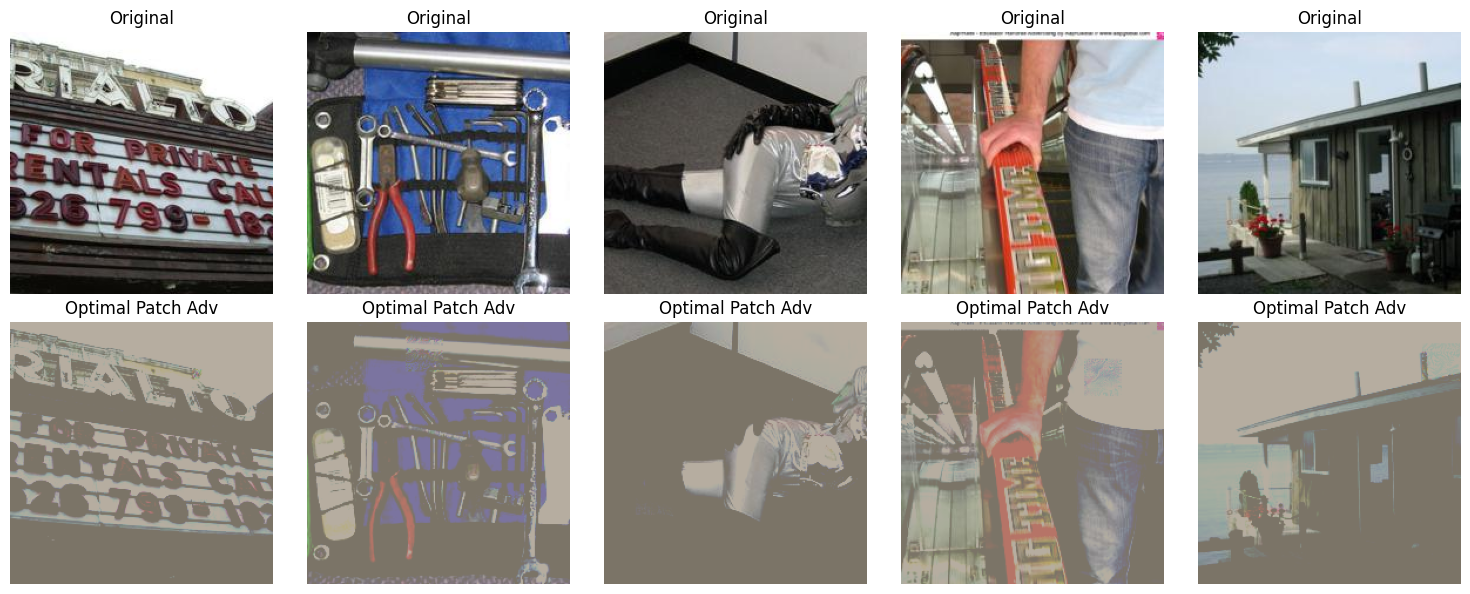

In [22]:
import matplotlib.pyplot as plt
import numpy as np

idxs = np.random.choice(len(optimal_adv_images), size=5, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for i, idx in enumerate(idxs):
    # Original image from dataset
    orig = (dataloader.dataset[idx][0] * torch.tensor(std_norms)[:, None, None] +
            torch.tensor(mean_norms)[:, None, None]).permute(1, 2, 0).numpy()
    
    # Adversarial image from optimal patch attack
    adv  = (optimal_adv_images[idx] * torch.tensor(std_norms)[:, None, None] +
            torch.tensor(mean_norms)[:, None, None]).permute(1, 2, 0).numpy()

    axes[0, i].imshow(np.clip(orig, 0, 1))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(np.clip(adv, 0, 1))
    axes[1, i].axis('off')
    axes[1, i].set_title("Optimal Patch Adv")

plt.tight_layout()
plt.savefig("Ori-PatchPGD.png")
plt.show()

In [23]:
# Define which models you want to evaluate
model_constructors = {
    "densenet121":     (torchvision.models.densenet121,     torchvision.models.DenseNet121_Weights.IMAGENET1K_V1),
    "efficientnet_b0": (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1),
    "mobilenet_v2":    (torchvision.models.mobilenet_v2,    torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2),
    "ViT_L_32":        (torchvision.models.vit_l_32, torchvision.models.ViT_L_32_Weights.IMAGENET1K_V1)

}

# List the model names you actually want to run:
model_names = ["densenet121", "efficientnet_b0", "mobilenet_v2", "ViT_L_32"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your four datasets 
orig_images = torch.stack([dataloader.dataset[i][0] for i in range(len(dataloader.dataset))])
orig_labels = torch.tensor([labels_list[l] for l in dataloader.dataset.targets])
fgsm_images,  fgsm_labels  = torch.load("Adversarial_Test_Set_1.pt")
pgd_images,   pgd_labels   = torch.load("Adversarial_Test_Set_2.pt")
patch_images, patch_labels = torch.load("Adversarial_Test_Set_3_PGD.pt")

datasets = {
    "Original": (orig_images,   orig_labels),
    "FGSM":     (fgsm_images,   fgsm_labels),
    "PGD":      (pgd_images,    pgd_labels),
    "PatchPGD": (patch_images,  patch_labels),
}

# Reusable evaluation function
def eval_on(images, labels, model, batch_size=32):
    ds     = TensorDataset(images, labels)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    total, top1, top5 = 0, 0, 0
    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out = model(imgs)
            p1  = out.topk(1, dim=1).indices.view(-1)
            p5  = out.topk(5, dim=1).indices
            top1 += (p1 == labs).sum().item()
            for i in range(labs.size(0)):
                if labs[i].item() in p5[i].tolist():
                    top5 += 1
            total += labs.size(0)
    return top1/total, top5/total

# Loop over models and datasets
records = []
for model_name in model_names:
    ctor, weights_enum = model_constructors[model_name]
    model = ctor(weights=weights_enum).eval().to(device)
    print(f"\n===== {model_name} =====")
    for ds_name, (imgs, labs) in datasets.items():
        acc1, acc5 = eval_on(imgs, labs, model)
        # print each dataset’s accuracy separately
        print(f"{ds_name:>8} → Top-1: {acc1*100:6.2f}%   Top-5: {acc5*100:6.2f}%")
        records.append({
            "Model":     model_name,
            "Dataset":   ds_name,
            "Top-1 Acc": acc1,
            "Top-5 Acc": acc5
        })
dataset_order = ["Original", "FGSM", "PGD", "PatchPGD"]
# Build a MultiIndex DataFrame
df = (
    pd.DataFrame(records)
      .set_index(["Model", "Dataset"])
      .sort_index()
)
df = df.reindex(
    pd.MultiIndex.from_product(
        [model_names, dataset_order],
        names=["Model", "Dataset"]
    )
)




===== densenet121 =====
Original → Top-1:  74.80%   Top-5:  93.60%
    FGSM → Top-1:  46.20%   Top-5:  75.20%
     PGD → Top-1:  46.00%   Top-5:  76.80%
PatchPGD → Top-1:  41.80%   Top-5:  65.00%

===== efficientnet_b0 =====
Original → Top-1:  83.00%   Top-5:  96.80%
    FGSM → Top-1:  60.00%   Top-5:  88.20%
     PGD → Top-1:  59.20%   Top-5:  89.20%
PatchPGD → Top-1:  44.80%   Top-5:  66.60%

===== mobilenet_v2 =====
Original → Top-1:  67.20%   Top-5:  86.40%
    FGSM → Top-1:  51.80%   Top-5:  75.20%
     PGD → Top-1:  49.60%   Top-5:  75.80%
PatchPGD → Top-1:  38.60%   Top-5:  62.60%

===== ViT_L_32 =====
Original → Top-1:  94.00%   Top-5:  99.20%
    FGSM → Top-1:  92.20%   Top-5:  98.80%
     PGD → Top-1:  93.40%   Top-5:  99.00%
PatchPGD → Top-1:  58.40%   Top-5:  78.60%


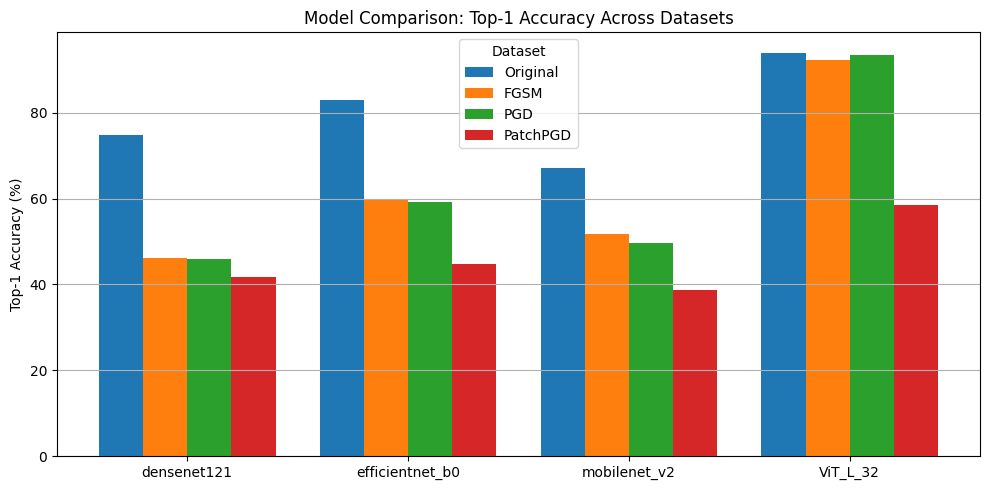

In [24]:
top1_mat = df['Top-1 Acc'].unstack('Dataset').loc[model_names, dataset_order].values * 100   

# Plot
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(10,5))
for i, ds in enumerate(dataset_order):
    plt.bar(x + (i - 1.5)*width, top1_mat[:, i], width, label=ds)

plt.xticks(x, model_names)
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Model Comparison: Top-1 Accuracy Across Datasets')
plt.legend(title='Dataset')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("Top-1.png")
plt.show()

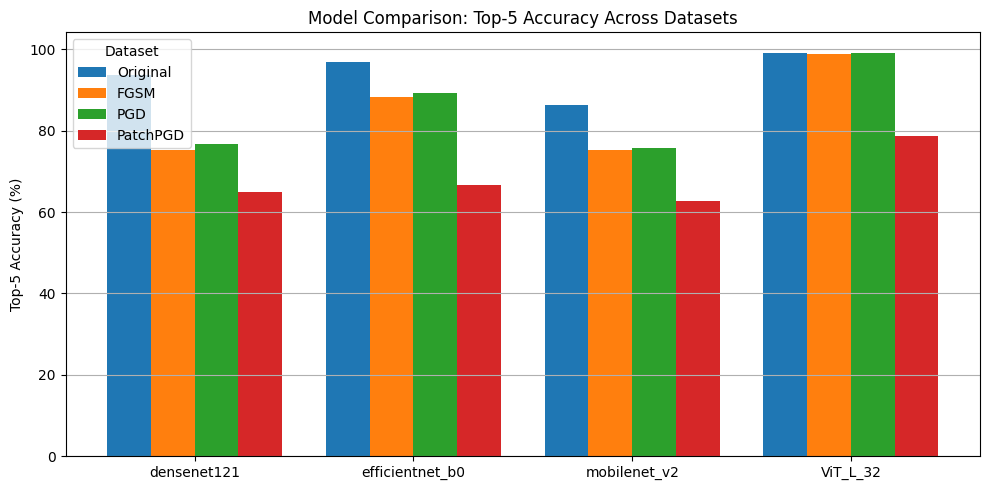

In [25]:
top1_mat = df['Top-5 Acc'].unstack('Dataset').loc[model_names, dataset_order].values * 100

# Plot
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(10,5))
for i, ds in enumerate(dataset_order):
    plt.bar(x + (i - 1.5)*width, top1_mat[:, i], width, label=ds)

plt.xticks(x, model_names)
plt.ylabel('Top-5 Accuracy (%)')
plt.title('Model Comparison: Top-5 Accuracy Across Datasets')
plt.legend(title='Dataset')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Top-5.png')
plt.show()

**Key Findings**

* **Initial performance**
  On the clean test set, the ResNet-34 model achieves a Top-1 accuracy of 76.20% and Top-5 accuracy of 94.20%.

* **FGSM vulnerability**
  The model is nearly destroyed by a single-step FGSM perturbation (ε=0.02), which reduces the Top-1 down to about 3.4% and Top-5 to 21.2%.

* **PGD robustness sweep**
  Iterative attacks are significantly more effective than one‐step methods. With just 5 PGD iterations, Top-1 falls below 1%, and a 10- or 20-step attack reduces Top-1 to near 0% and Top-5 to around 1.8%.

* **Patch-based attacks**
  The model is still crippled by spatially constrained patch PGD, even after hyperparameter tuning, with a best Top-1 of 6.4% and Top-5 of 29.6%. Adversarial patches are still a significant risk, despite being less destructive than dense perturbations.

---

**Trends Observed**

1. **Attack strength vs. iteration count**
   Single‐step attacks (FGSM) are surprisingly powerful, but increasing the number of PGD steps yields exponentially more damage upto a point after which there was significant/no performance increase.
2. **Trade-off in patch attacks**
   While patches must fit within a small region, but highly transferable adversarial examples can still be produced with careful adjustment of ε, step size (α), and iteration count.
3. **Normalization**
   Correctly scaling ε and clamping in normalized space is critical to enforce the intended perturbation budget without violating constraints.

---

**Lessons Learned**

* **Hyperparameter tuning is essential**
  A thorough sweep over ε, α, and iters can uncover the most damaging attack settings, what’s “best” for one model or dataset may not transfer to another as seen in the last part.
* **Patches don’t save you**
  The necessity of taking into account both dense and localized perturbations is highlighted by the fact that even patch attacks that are limited to a small area can significantly reduce accuracy.
* **Visualization helps**
  Inspecting original vs. adversarial examples reveals how subtle changes in pixel space translate to misclassification, guiding more intuitive defense strategies.

---

**Potential Mitigation Strategies**

* **Adversarial training**: Include both FGSM and multi‐step PGD examples (including patch‐based variants) during training to improve worst‐case robustness.
* **Data Augmentation**: Random resizing, padding, JPEG compression, or even bit‐depth reduction can disrupt structured perturbations.
* **Certified defenses**: Under L∞ constraints, methods such as randomized smoothing offer provable guarantees.
* **Architecture choices**: Exploring more robust architectures (e.g., Vision Transformers) may inherently reduce attack transferability as seen in last part.
* **Detection & ensemble methods**: Use multiple models to dilute any single vulnerability or deploy auxiliary networks to flag anomalous inputs.

You can significantly reduce the transferability of attacks and strengthen models against both dense and patch-based adversarial examples by combining these defenses, particularly adversarial training with a variety of perturbation types.
